In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argosim

from argosim.antenna_utils import *
from argosim.plot_utils import *
from argosim.data_utils import *
from argosim.clean import *
from argosim.imaging_utils import *

In [9]:
plt.rcParams['image.cmap'] = 'afmhot'

# Antenna parameters
x_lim = 100
y_lim = 100
n_antenna = 3*2
n_baselines = n_antenna*(n_antenna-1)
radius = 80
alpha = 120
f = 1200e6 # 1200 MHz


# Source tracking parameters
source_decl = -30/180*np.pi
array_lat = -30.7/180*np.pi
track_time = 4
delta_t = 5/60 # 300 segs
t_0 = -0.5
n_times = int(track_time/delta_t)
# Multiband parameters
bandwidth = 100e6
n_freqs = 100


# Sky model
nx = 512
ny = 512
pix_sizes = [2, 2, 3, 4]
amplitudes = [.4, .6, 1, 1]
sky = n_source_sky((nx,ny), pix_sizes, amplitudes)

# UV parameters
uv_dim = sky.shape[0]

arr = y_antenna_arr(n_antenna//3, radius, alpha)
arr_center = random_antenna_arr(1, int(x_lim/5), int(y_lim/5))
arr = np.concatenate((arr,arr_center), axis=0)
# Get baselines
base_arr = get_baselines(arr)
# track = uv_time_int(base_arr, array_lat, source_decl, track_time, delta_t, t_0)
track = uv_track_multiband(base_arr, array_lat, source_decl, track_time, t_0, n_times, f, bandwidth, n_freqs)
# Get uv mask
uv_plane = get_uv_plane(track,uv_dim)
uv_plane_mask = get_uv_mask(uv_plane)
# Get the dirty beam
beam = get_beam(uv_plane)
# Get the sky model FT
sky_uv = get_sky_uv(sky)
# Sample Fourier space
obs_uv = get_obs_uv(sky_uv,uv_plane_mask)
# Get observed sky
obs_sky = get_obs_sky(obs_uv, abs=True)
# Add noise
sigma = 3e-3*np.sum(obs_sky**2)
obs_sky += np.random.randn(obs_sky.shape[0],obs_sky.shape[1])*sigma


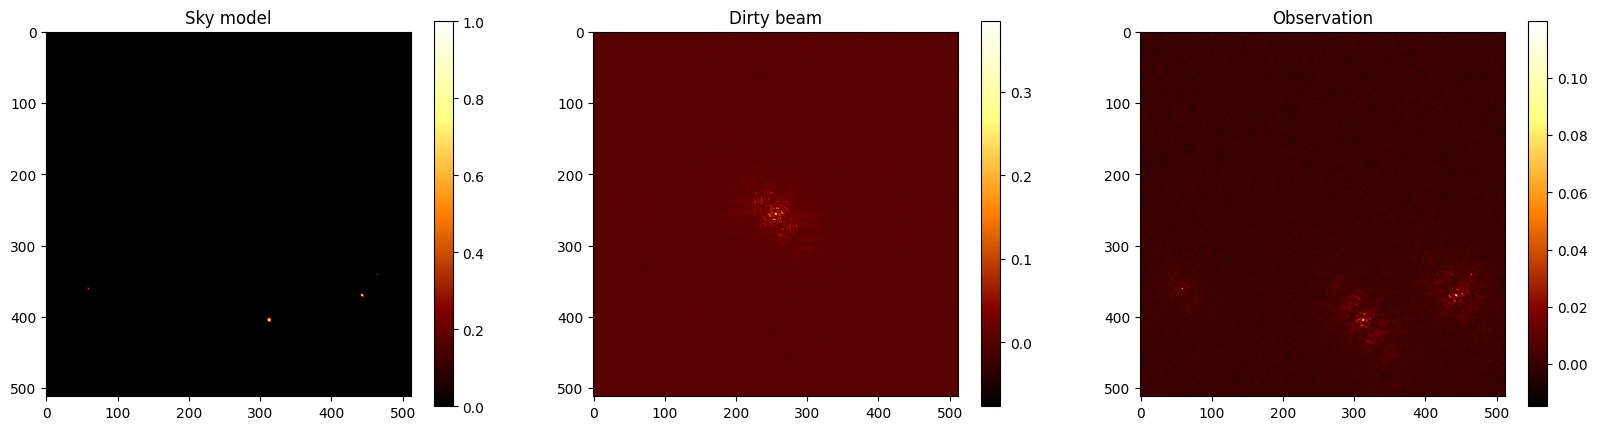

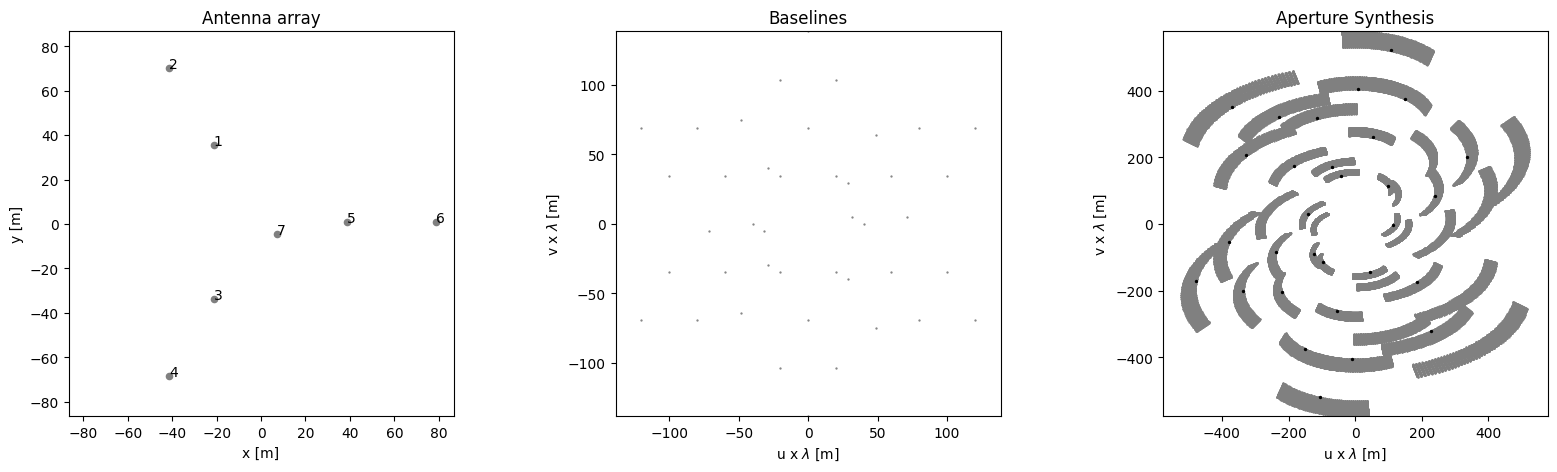

In [10]:
# Plot sky model, dirty beam and observation
fig, ax = plt.subplots(1,3,figsize=(20,5))
im=ax[0].imshow(sky, vmin=0, vmax=1)
plt.colorbar(im, ax=ax[0])
plot_beam(beam, ax=ax[1],fig=fig)
im=ax[2].imshow(obs_sky)
plt.colorbar(im, ax=ax[2])
ax[0].set_title('Sky model')
ax[1].set_title('Dirty beam')
ax[2].set_title('Observation')
# plt.savefig('/home/figures/observation.pdf')

# Plot antenna array, baselines and aperture synthesis
fig, ax = plt.subplots(1,3,figsize=(20,5))
plot_antenna_arr(arr, ax=ax[0],fig=fig)
plot_baselines(base_arr, ax=ax[1],fig=fig)
plot_baselines(track, n_baselines=n_baselines ,ax=ax[2],fig=fig)
ax[0].set_title('Antenna array')
ax[1].set_title('Baselines')
ax[2].set_title('Aperture Synthesis')
# plt.savefig('/home/figures/antenna_array.pdf')

plt.show()

In [13]:

#---------------#
# CLEAN algorithm

# Clean hyperparams
max_it = 500
treshold = 3*sigma
clean_gamma = 0.2
clean_beam_size_px = 4 #beam.shape[0]//32


# Clean initialisation
i=0
X=np.zeros(sky.shape)
X_delta = np.zeros(sky.shape)
Y=obs_sky.copy()
B_norm = np.fft.ifftshift(beam/np.max(beam))
# Get the clean beam
B_clean = gauss_source(nx, ny, np.array([0,0]), fwhm_pix=clean_beam_size_px)

x_max_list = []
y_max_list = []
max_val_list = []

while i < max_it:
    # Search maximum in dirty obs
    max_val, x_max, y_max, shift_x, shift_y = find_peak(Y)
    if max_val<treshold:
        print('Treshold reached. Stop after {} iterations.'.format(i))
        break
    # Subtract beam
    Y -= max_val*clean_gamma*shift_beam(B_norm, shift_x, shift_y)
    # Save clean component
    X_delta[y_max,x_max] += max_val*clean_gamma
    X += clean_gamma*max_val*shift_beam(B_clean, shift_x, shift_y)
    # Track max peaks
    x_max_list.append(x_max)
    y_max_list.append(y_max)
    max_val_list.append(max_val)
    i+=1

# Add residuals
X += Y

Treshold reached. Stop after 251 iterations.


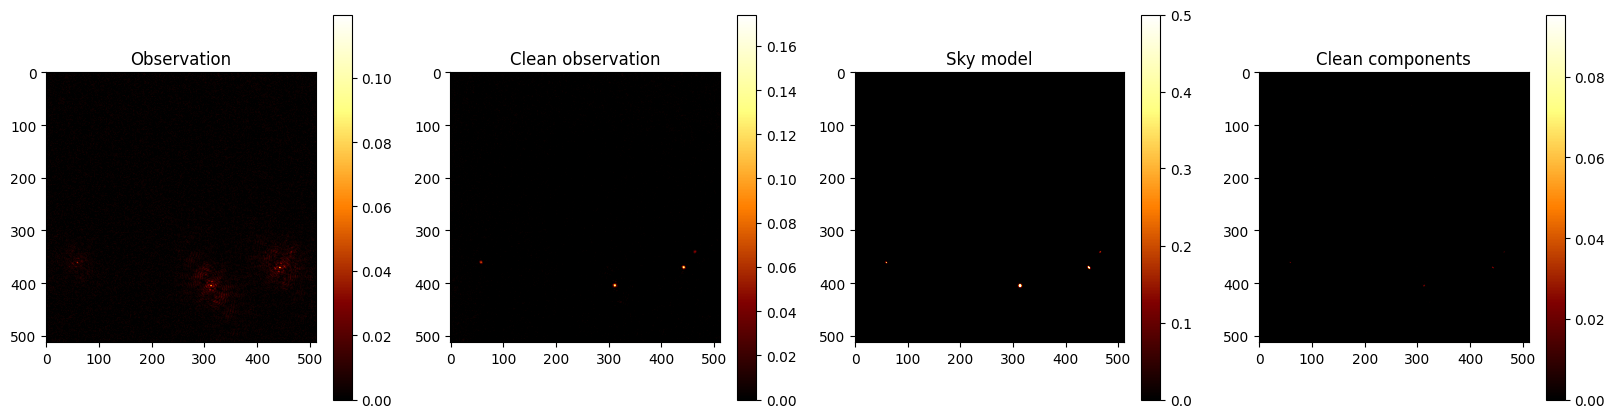

In [14]:
# Plot clean observation
fig, ax = plt.subplots(1,4,figsize=(20,5))
im=ax[0].imshow(obs_sky, vmin=0)
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Observation')
im=ax[1].imshow(X, vmin=0)
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Clean observation')
im=ax[2].imshow(sky,vmin=0,vmax=0.5)
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Sky model')
im=ax[3].imshow(X_delta, vmin=0)
plt.colorbar(im, ax=ax[3])
ax[3].set_title('Clean components')

# plt.savefig('/home/figures/clean_observation.pdf')
plt.show()

# Clean function

In [15]:
# plt.imshow(gauss_source(beam.shape[1], beam.shape[0], np.array([0,0]), fwhm_pix=beam.shape[0]//32))
# plt.colorbar()
# print(np.max(gauss_source(beam.shape[1], beam.shape[0], np.array([0,0]), np.eye(2) ,fwhm_pix=beam.shape[0]//32)))

In [16]:
I_clean, sky_model = clean_hogbom(obs_sky, beam, 0.4, 500, sigma, clean_beam_size_px)

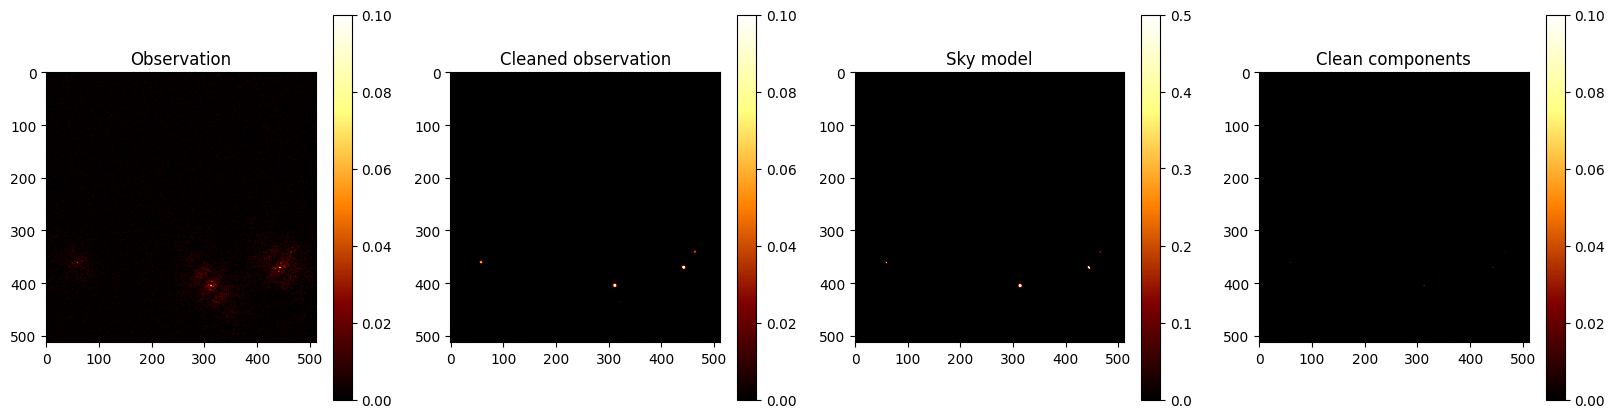

In [17]:
vm = .1
# Plot clean observation
fig, ax = plt.subplots(1,4,figsize=(20,5))
im=ax[0].imshow(obs_sky, vmin=0, vmax=vm)
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Observation')
im=ax[1].imshow(I_clean, vmin=0, vmax=vm)
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Cleaned observation')
im=ax[2].imshow(sky,vmin=0,vmax=0.5)
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Sky model')
# plt.savefig('/home/figures/clean_observation.pdf')
im=ax[3].imshow(sky_model, vmin=0, vmax=vm)
plt.colorbar(im, ax=ax[3])
ax[3].set_title('Clean components')
plt.show()